In [71]:
using Test

In [72]:
using Plots
using Printf

In [73]:
using Unitful

In [74]:
using DataFrames

In [75]:
using CSV

In [76]:
import Unitful:
    nm, μm, mm, cm, m, km,
    mg, g, kg,
    ps, ns, μs, ms, s, minute, hr, d, yr, Hz, kHz, MHz, GHz,
    eV,
    μJ, mJ, J,
	μW, mW, W

In [77]:
include("../src/LaserLab.jl")

Main.LaserLab

In [78]:
epl375 = LaserLab.PulsedLaser(375.0nm, 140.0mW, 1.0MHz, 65.0ps)

Main.LaserLab.PulsedLaser(375.0 nm, 140.0 mW, 1.0 MHz, 0.0091 mW, 65.0 ps)

In [79]:
lmu_40x_nuv = LaserLab.Objective("LMU-40X-NUV", 5.3mm, 5.1mm, 40.0)

Main.LaserLab.Objective("LMU-40X-NUV", 0.48113207547169806, 40.0, 5.3 mm, 5.1 mm)

### Gaussian Laser

    GaussianLaser 
	
Representation of a Gaussian laser defined by a laser, the location of the waist (z0) and the waist radius (w0)  

#### Fields
- `laser::Laser`       : A Laser  
- `w0::Unitful.Length` : radius of the waist  
- `z0::Unitful.Length` : location of the waist (computed from w0)
- `I0::typeof(1.0mW/cm^2)` : Intensity of the beam at (0,0) (computed from w0)
- `θ0::Real ` : divergence of the beam  (computed from w0)

#### Definition of gaussian laser
- We need a laser, such as the epl375
- We nee to define w0. Assuming the large zr approach (e.g, the beam fills the entrance pupil of the objective), we can take 2w0 = d, where d is the diameter of the pupil of the objective

In [80]:
w0 = lmu_40x_nuv.d /2.0

2.55 mm

In [81]:
gepl375 = LaserLab.GaussianLaser(epl375, w0)

Main.LaserLab.GaussianLaser(Main.LaserLab.PulsedLaser(375.0 nm, 140.0 mW, 1.0 MHz, 0.0091 mW, 65.0 ps), 2.55 mm, 0.05447521661324701 mm² nm⁻¹, 0.08909250178462116 mW cm⁻², 4.681027737996922e-5)

#### Power density delivered by the beam
- Max is 3J/cm2

In [82]:
uconvert(W/cm^2, gepl375.I0) 

8.909250178462117e-5 W cm⁻²

#### Propagate paralell beam
- When the beam fills up the objective of the entrance pupil of the objective (in the approx of large zr), one can compute wr which depends ony of the NA of the objective in the \lambda of the laser

    propagate_paralel_beam(laser::Laser, obj::Objective)

returns a gaussian laser with parameter w0 resulting from focusing the paralell laser beam 
filling the entrance pupil of the objective.    
 
#### Fields

- `laser::Laser` : A  laser filling the entrance pupil of the objective (assuming parallell rays)
- `obj::Objective` : An objective, used to focuse the laser in the sample. 


In [83]:
g2epl375 = LaserLab.propagate_paralell_beam(epl375, lmu_40x_nuv)

Main.LaserLab.GaussianLaser(Main.LaserLab.PulsedLaser(375.0 nm, 140.0 mW, 1.0 MHz, 0.0091 mW, 65.0 ps), 248.09447011383688 nm, 515.6473300405237 nm, 9.41211764434409e6 mW cm⁻², 0.4811320754716981)

In [84]:
@test g2epl375.w0 ≈ epl375.λ/(π * lmu_40x_nuv.NA)
	


Test Passed

#### Power, beam spot and depth of focus

In [85]:
uconvert(W/cm^2, g2epl375.I0) 

9412.117644344089 W cm⁻²

In [86]:
LaserLab.spot_size(g2epl375)  

496.18894022767375 nm

In [87]:
@test LaserLab.spot_size(g2epl375) ≈ 2 * g2epl375.w0

Test Passed

In [88]:
LaserLab.angular_divergence(g2epl375) 

0.9622641509433962

In [112]:
@test LaserLab.angular_divergence(g2epl375) ≈ 2 * g2epl375.θ0

Test Passed

In [90]:
LaserLab.depth_of_focus(g2epl375)

1031.2946600810474 nm

In [91]:
@test LaserLab.depth_of_focus(g2epl375)  ≈ 2 * g2epl375.z0

Test Passed

    W(gl::GaussianLaser)

returns the beam width: $W(z) = W_0 \sqrt{1 + (z/z_0)^2}$

#### Fields
	- `gl::GaussianLaser`       : A gaussian Laser 
    

In [92]:
fwz = LaserLab.W(g2epl375)

(::Main.LaserLab.var"#Wz#4"{Main.LaserLab.GaussianLaser}) (generic function with 1 method)

In [97]:
fwz(100.0*mm)

4.811320754780946e7 nm

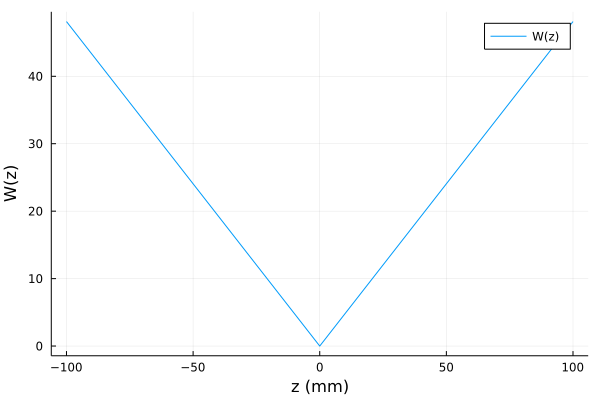

In [99]:
wl=-100.0:1.0:100.0
plot(wl, fwz.(wl*mm)/mm, label="W(z)")
xlabel!("z (mm)")
ylabel!("W(z)")


    I(gl::GaussianLaser)

returns the beam Intensity: $I(\rho, z) = I_0 ( W_0 / W(z))^2 \exp{-2 \rho^2/W^2(z)} $

#### Fields
- `gl::GaussianLaser`       : A gaussian Laser 


In [100]:
fI = LaserLab.I(g2epl375) 

(::Main.LaserLab.var"#Irz#6"{Main.LaserLab.GaussianLaser, Main.LaserLab.var"#Wz#4"{Main.LaserLab.GaussianLaser}}) (generic function with 1 method)

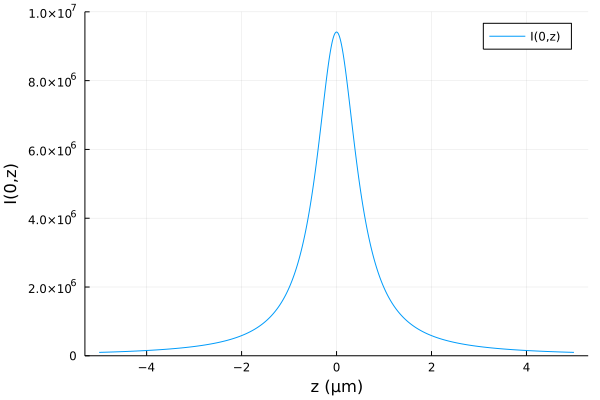

In [109]:
wl=-5.0:0.01:5.0
plot(wl, fI.(0.0*μm, wl*μm)/(mW * cm^-2), label="I(0,z)")
ylims!((0.0,1.0e+7))
xlabel!("z (μm)")
ylabel!("I(0,z)")

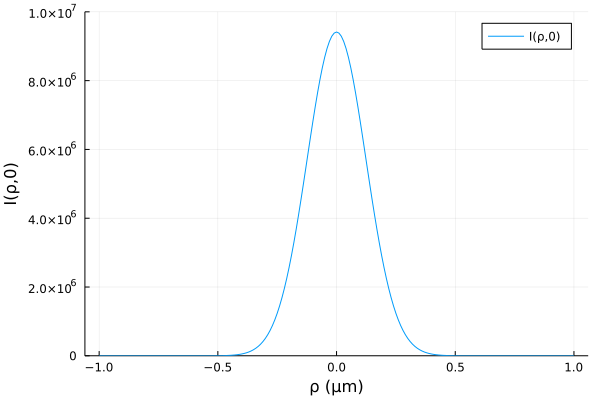

In [111]:
wl=-1.0:0.01:1.0
plot(wl, fI.(wl*μm, 0.0*μm )/(mW * cm^-2), label="I(ρ,0)")
ylims!((0.0,1.0e+7))
xlabel!("ρ (μm)")
ylabel!("I(ρ,0)")